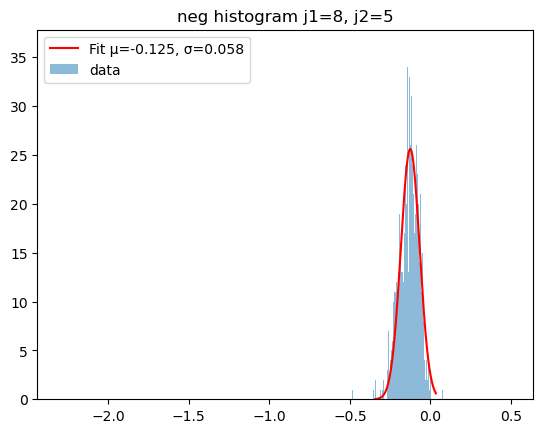

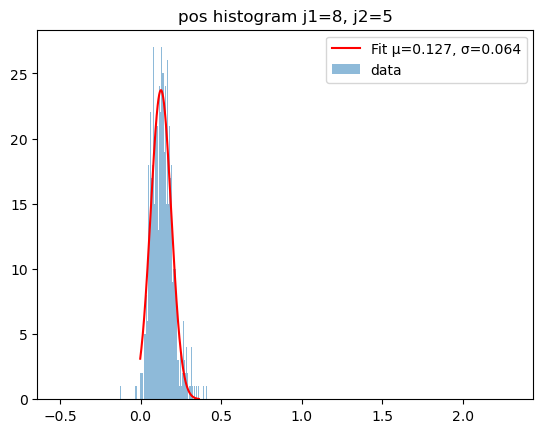

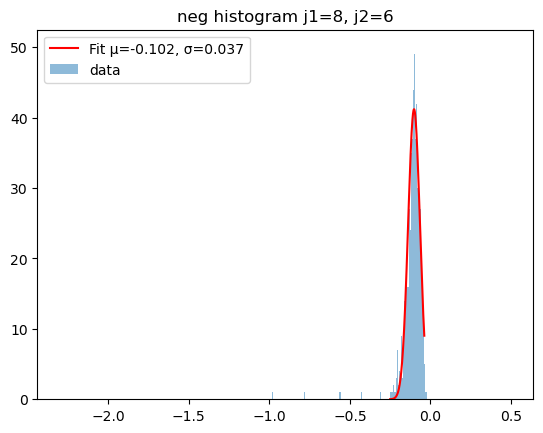

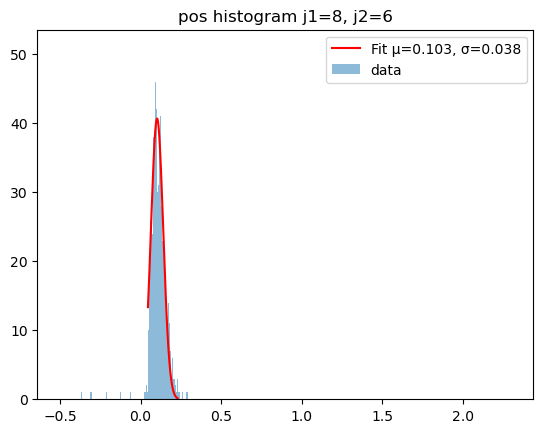

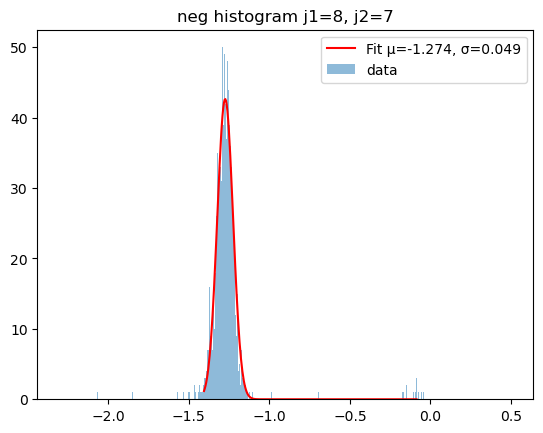

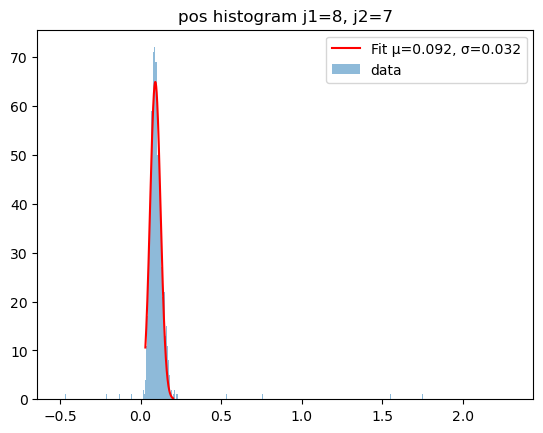

neg_8_8 has low_stats
pos_8_8 has low_stats


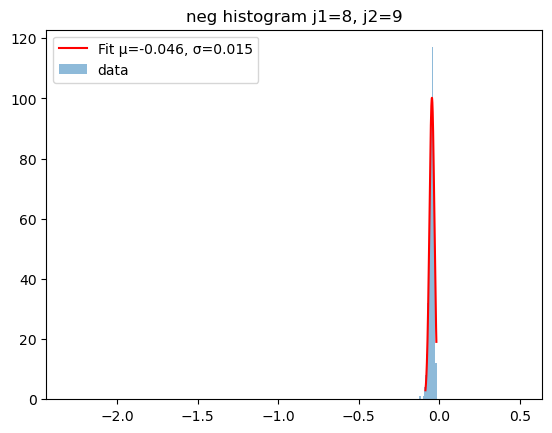

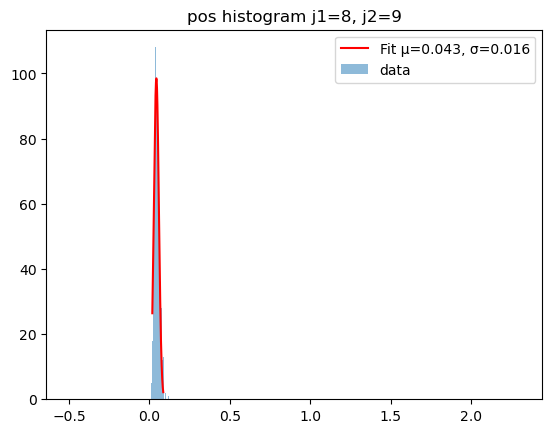

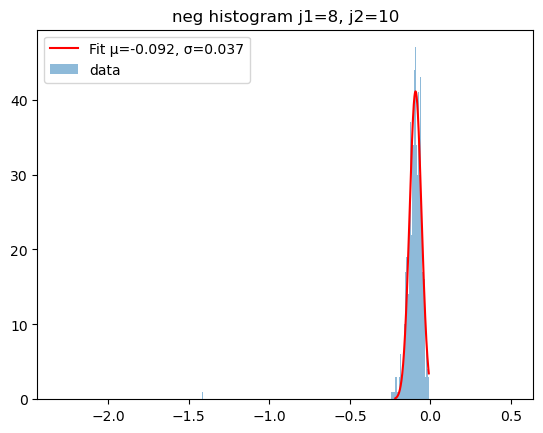

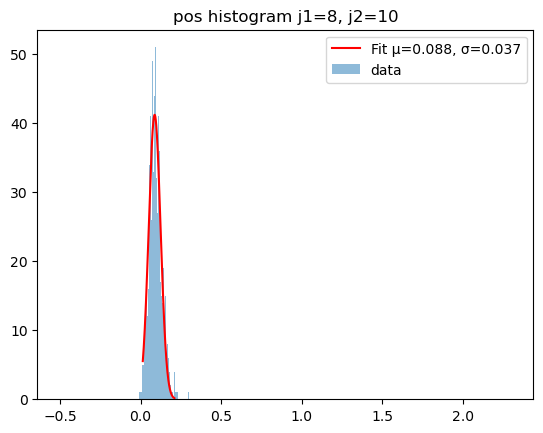

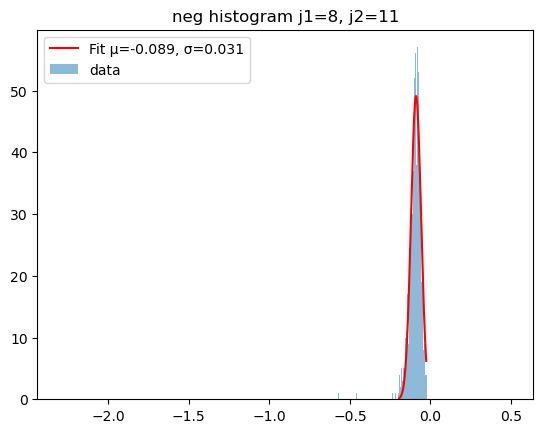

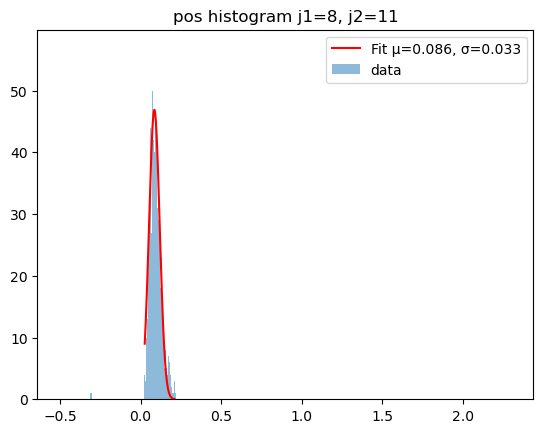

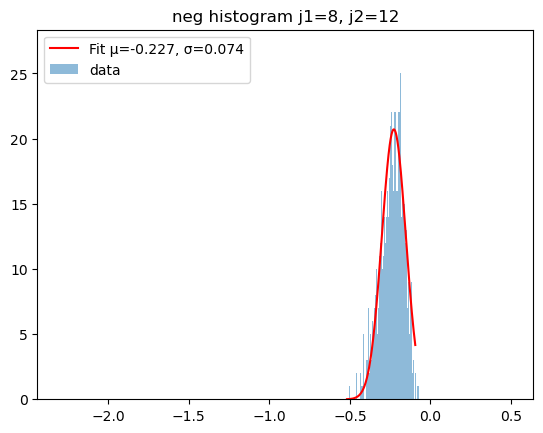

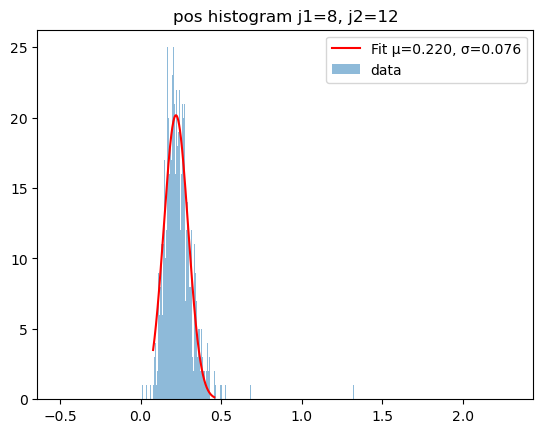

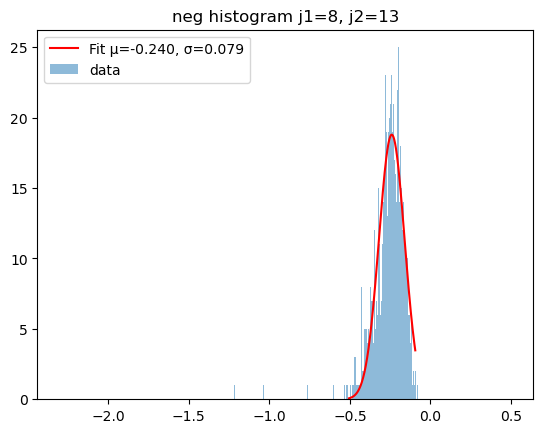

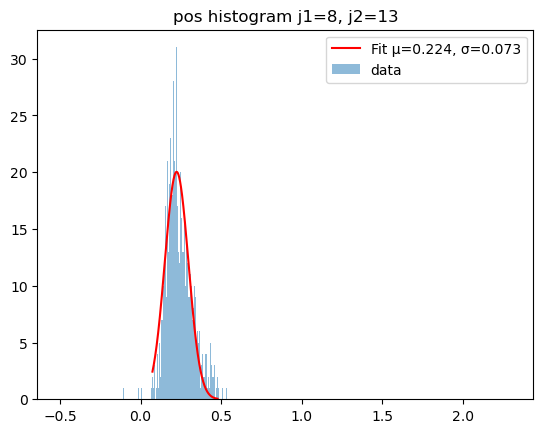

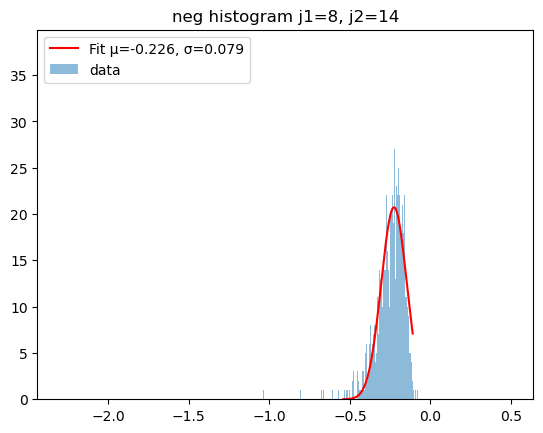

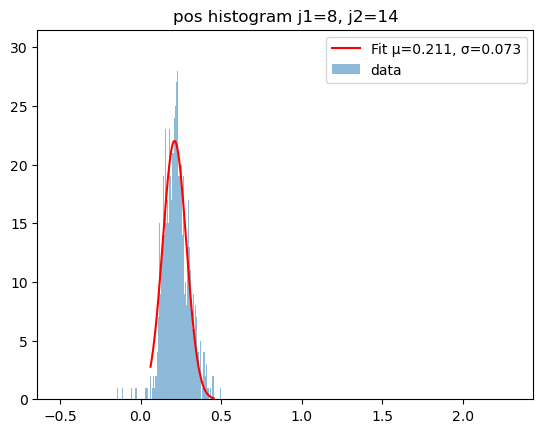

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

j1 = int(sys.argv[1])

base_dir = os.getcwd() 
in_dir = os.path.join(base_dir, "../histograms_with_fixed_range")
out_dir = os.path.join(base_dir, "fit_results")
out_dir_figs = os.path.join(base_dir, "fit_figures")

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

for j2 in range(101):
    npz_path = os.path.join(in_dir, f"xtalk_{j1}_{j2}.npz")

    with np.load(npz_path) as data:
        neg_counts = data["neg_counts"]
        neg_bins = data["neg_bins"]
        pos_counts = data["pos_counts"]
        pos_bins = data["pos_bins"]

    neg_x = (neg_bins[1:]+neg_bins[:-1])/2
    neg_y = neg_counts
    pos_x = (pos_bins[1:]+pos_bins[:-1])/2
    pos_y = pos_counts

    for label, counts, bins in [("neg", neg_counts, neg_bins), ("pos", pos_counts, pos_bins)]:
        total_events = np.sum(counts)
        if total_events < 100:
            # Too few events to fit reliably
            result = dict(success=False, reason="low_stats", mu=np.nan, sigma=np.nan)
            np.savez(os.path.join(out_dir, f"fit_{label}_{j1}_{j2}.npz"), **result)
            print(f"{label}_{j1}_{j2} has low_stats")
            continue

        x = 0.5 * (bins[1:] + bins[:-1])
        y = counts

        # Smooth counts to avoid spikes due to noise
        smooth_y = uniform_filter1d(y, size=3)
        peak_idx = np.argmax(smooth_y)
        peak_x = x[peak_idx]

        # Restrict fit region: within ±3 std estimates around peak
        # Use only bins where y is > 5% of the max to ignore far tails
        mask = y > 0.05 * np.max(y)
        x_fit = x[mask]
        y_fit = y[mask]

        if len(x_fit) < 5:
            result = dict(success=False, reason="insufficient_fit_points", mu=np.nan, sigma=np.nan)
            np.savez(os.path.join(out_dir, f"fit_{label}_{j1}_{j2}.npz"), **result)
            print(f"{label}_{j1}_{j2} has insufficient_fit_points")
            continue

        # Initial parameter guesses
        A0 = np.max(y_fit)
        mu0 = np.average(x_fit, weights=y_fit)
        sigma0 = np.sqrt(np.average((x_fit - mu0)**2, weights=y_fit))

        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=[A0, mu0, sigma0])
            A, mu, sigma = popt
            success = True
            reason = "ok"
        except Exception as e:
            A, mu, sigma = np.nan, np.nan, np.nan
            success = False
            reason = str(e)
            print("Failed with:")
            print(e)

        # Save results
        result = dict(success=success, reason=reason, A=A, mu=mu, sigma=sigma)
        np.savez(os.path.join(out_dir, f"fit_{label}_{j1}_{j2}.npz"), **result)

        if success:
            plt.figure()
            plt.bar(x, y, width=np.diff(bins), alpha=0.5, label="data")
            x_dense = np.linspace(min(x_fit), max(x_fit), 300)
            plt.plot(x_dense, gaussian(x_dense, *popt), 'r-', label=f"Fit μ={mu:.3f}, σ={sigma:.3f}")
            plt.title(f"{label} histogram j1={j1}, j2={j2}")
            plt.legend()
            plt.savefig(os.path.join(out_dir_figs, f"fit_{label}_{j1}_{j2}.png"))
            plt.show()